# DATA603 Big Data Processing Project 
Group 3: Pooja Kangokar Pranesh, Yun-Zih Chen, Elizabeth Cardosa

The goal of this project is leverage big data technologies to train a model using the UCI ML Drug Review dataset to predict the star rating of drug based on the sentiment of the review. This model will then perform inference in a streaming manner on ‘real-time’ reviews coming in. This application can then be used to help potential customers understand the overall sentiment towards a drug and if it might be useful for them. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
working_folder = "/content/drive/My Drive/UMBC Fall 2022/DATA603 Big Data Processing/Project/Data/"

# Install Libraries and Dependencies

In [3]:
# Install PySpark and Spark NLP
! pip install -qq pyspark==3.2.1 findspark #pyspark==3.1.2 spark-nlp findspark

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 44.8 MB/s 


In [4]:
import pyspark.pandas as ps
import pandas as pd

In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
import findspark

In [6]:
# To initialize PySpark
findspark.init()
#To verify the automatically detected location
findspark.find ()
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [7]:
sc = SparkContext.getOrCreate();

# Read-in Dataset


## Dataset: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29


The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study

- sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects,
- the transferability of models among domains, i.e. conditions, and
- the transferability of models among different data sources (see 'Drug Review Dataset (Druglib.com)').

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

Attribute Information:

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful


Important notes:

When using this dataset, you agree that you
1. only use the data for research purposes
2. don't use the data for any commerical purposes
3. don't distribute the data to anyone else
4. cite us

Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link] 

## Load in Test Data

In [8]:
# Read in training data file
customschema = StructType([
  StructField("UniqueID", IntegerType(), True)
  ,StructField("drugName", StringType(), True)
  ,StructField("condition", StringType(), True)
  ,StructField("review", StringType(), True)
  ,StructField("rating", DoubleType(), True)
  ,StructField("date", StringType(), True)
  ,StructField("usefulCount", IntegerType(), True)
  ,StructField("sentiment", DoubleType(), True)
  ])

In [9]:
df_test = spark.read.format("csv")\
           .option("delimiter", "|")\
           .option("header", "true")\
           .option("quote", "\"")\
           .option("escape", "\"")\
           .option("multiLine","true")\
           .option("quoteMode","ALL")\
           .option("mode","PERMISSIVE")\
           .option("ignoreLeadingWhiteSpace","true")\
           .option("ignoreTrailingWhiteSpace","true")\
           .option("parserLib","UNIVOCITY")\
           .schema(customschema)\
           .load(working_folder + "drug_reviews_with_sentiment_test.csv")

In [10]:
df_test.count()

53200

In [11]:
df_test.show(5)

+--------+---------------+--------------------+--------------------+------+------------------+-----------+-------------------+
|UniqueID|       drugName|           condition|              review|rating|              date|usefulCount|          sentiment|
+--------+---------------+--------------------+--------------------+------+------------------+-----------+-------------------+
|  163740|    Mirtazapine|          Depression|"I&#039;ve tried ...|  10.0| February 28, 2012|         22|                0.0|
|  206473|     Mesalamine|Crohn's Disease, ...|"My son has Crohn...|   8.0|      May 17, 2009|         17| 0.5666666666666667|
|  159672|        Bactrim|Urinary Tract Inf...|"Quick reduction ...|   9.0|September 29, 2017|          3| 0.3333333333333333|
|   39293|       Contrave|         Weight Loss|"Contrave combine...|   9.0|     March 5, 2017|         35|          0.1390625|
|   97768|Cyclafem 1 / 35|       Birth Control|"I have been on t...|   9.0|  October 22, 2015|          4|0.260

## Load in and Explore Training Data

In [12]:
# Read in training data file
customschema = StructType([
  StructField("UniqueID", IntegerType(), True)
  ,StructField("drugName", StringType(), True)
  ,StructField("condition", StringType(), True)
  ,StructField("review", StringType(), True)
  ,StructField("rating", DoubleType(), True)
  ,StructField("date", StringType(), True)
  ,StructField("usefulCount", IntegerType(), True)
  ,StructField("sentiment", DoubleType(), True)
  ])

df = spark.read.format("csv")\
           .option("delimiter", "|")\
           .option("header", "true")\
           .option("escape", "\"")\
           .option("multiLine","true")\
           .option("quoteMode","ALL")\
           .option("mode","PERMISSIVE")\
           .option("ignoreLeadingWhiteSpace","true")\
           .option("ignoreTrailingWhiteSpace","true")\
           .option("parserLib","UNIVOCITY")\
           .schema(customschema)\
           .load(working_folder + "drug_reviews_with_sentiment_train.csv")

In [13]:
df.count()

159498

In [14]:
df.show(5)

+--------+--------------------+--------------------+--------------------+------+-----------------+-----------+-------------------+
|UniqueID|            drugName|           condition|              review|rating|             date|usefulCount|          sentiment|
+--------+--------------------+--------------------+--------------------+------+-----------------+-----------+-------------------+
|  206461|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|     May 20, 2012|         27|                0.0|
|   95260|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|   April 27, 2010|        192|0.16833333333333333|
|   92703|              Lybrel|       Birth Control|"I used to take a...|   5.0|December 14, 2009|         17|0.06720959595959597|
|  138000|          Ortho Evra|       Birth Control|"This is my first...|   8.0| November 3, 2015|         10|0.17954545454545456|
|   35696|Buprenorphine / n...|   Opiate Dependence|"Suboxone has com...|   9.0|Nov

In [15]:
df.select('sentiment').summary().show()

+-------+--------------------+
|summary|           sentiment|
+-------+--------------------+
|  count|              159498|
|   mean| 0.06471531654907943|
| stddev| 0.22233595288111896|
|    min|                -1.0|
|    25%|-0.04333333333333333|
|    50%|0.057962962962962966|
|    75%| 0.17353535353535351|
|    max|                 1.0|
+-------+--------------------+



## Train model to predict star rating based off of the 'condition', 'usefulCount', and 'sentiment' with 'rating' as the target

In [16]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [17]:
df_train = df.drop('date', 'document', 'token', 'class')

In [18]:
df_train.show()

+--------+--------------------+--------------------+--------------------+------+-----------+--------------------+
|UniqueID|            drugName|           condition|              review|rating|usefulCount|           sentiment|
+--------+--------------------+--------------------+--------------------+------+-----------+--------------------+
|  206461|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|         27|                 0.0|
|   95260|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|        192| 0.16833333333333333|
|   92703|              Lybrel|       Birth Control|"I used to take a...|   5.0|         17| 0.06720959595959597|
|  138000|          Ortho Evra|       Birth Control|"This is my first...|   8.0|         10| 0.17954545454545456|
|   35696|Buprenorphine / n...|   Opiate Dependence|"Suboxone has com...|   9.0|         37| 0.19444444444444445|
|  155963|              Cialis|Benign Prostatic ...|"2nd day on 5mg s...|   2.0|        

In [19]:
target = 'rating'
numeric_cols = ['usefulCount','sentiment']
#categorical_cols = ['condition']

In [20]:
# Use String Indexer to convert categorical values to a numeric index
#stringIndex = StringIndexer(inputCols=categorical_cols, handleInvalid='skip', outputCols=[x + "_idx" for x in categorical_cols])
#stringIndex_model = stringIndex.fit(df_train)
#train_df = stringIndex_model.transform(df_train).drop(*categorical_cols)

In [21]:
# Assemble the inputs into the format needed for the model
assemblerInputs = numeric_cols 
vectorAssembler = VectorAssembler(inputCols= assemblerInputs, outputCol="features")
train_df = vectorAssembler.transform(df_train).select('features', target)

In [22]:
train_df.show(5)

+--------------------+------+
|            features|rating|
+--------------------+------+
|          [27.0,0.0]|   9.0|
|[192.0,0.16833333...|   8.0|
|[17.0,0.067209595...|   5.0|
|[10.0,0.179545454...|   8.0|
|[37.0,0.194444444...|   9.0|
+--------------------+------+
only showing top 5 rows



In [120]:
rf = RandomForestRegressor(labelCol=target)

In [121]:
pipeline_rf = Pipeline(stages= [vectorAssembler, rf]) 

In [122]:
# Fit Random Forest Model with pipeline
rf_pipelineModel = pipeline_rf.fit(df_train)

In [123]:
train_preds = rf_pipelineModel.transform(df_train)

In [124]:
# Select example rows to display.
train_preds.show(5)

+--------+--------------------+--------------------+--------------------+------+-----------+-------------------+--------------------+-----------------+
|UniqueID|            drugName|           condition|              review|rating|usefulCount|          sentiment|            features|       prediction|
+--------+--------------------+--------------------+--------------------+------+-----------+-------------------+--------------------+-----------------+
|  206461|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|         27|                0.0|          [27.0,0.0]|6.916662449983155|
|   95260|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|        192|0.16833333333333333|[192.0,0.16833333...| 8.81945358190911|
|   92703|              Lybrel|       Birth Control|"I used to take a...|   5.0|         17|0.06720959595959597|[17.0,0.067209595...|7.041852692318409|
|  138000|          Ortho Evra|       Birth Control|"This is my first...|   8.0|        

In [125]:
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(train_preds)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 2.93095


In [126]:
# Drop unimportant columns for model 
df_test = df_test.drop('date', 'document', 'token', 'class')
# Drop rows with missing values
df_test = df_test.dropna()

In [127]:
## Drop rows where condition contains irrelevant strings
df_test = df_test.where(~df_test.condition.contains("</span>"))

In [31]:
df_test.count()

53200

In [128]:
df_test.show(5)

+--------+---------------+--------------------+--------------------+------+-----------+-------------------+
|UniqueID|       drugName|           condition|              review|rating|usefulCount|          sentiment|
+--------+---------------+--------------------+--------------------+------+-----------+-------------------+
|  163740|    Mirtazapine|          Depression|"I&#039;ve tried ...|  10.0|         22|                0.0|
|  206473|     Mesalamine|Crohn's Disease, ...|"My son has Crohn...|   8.0|         17| 0.5666666666666667|
|  159672|        Bactrim|Urinary Tract Inf...|"Quick reduction ...|   9.0|          3| 0.3333333333333333|
|   39293|       Contrave|         Weight Loss|"Contrave combine...|   9.0|         35|          0.1390625|
|   97768|Cyclafem 1 / 35|       Birth Control|"I have been on t...|   9.0|          4|0.26092592592592595|
+--------+---------------+--------------------+--------------------+------+-----------+-------------------+
only showing top 5 rows



In [129]:
df_test = df_test.drop('date', 'document', 'token', 'class')

In [130]:
test_preds = rf_pipelineModel.transform(df_test)

In [135]:
# Select example rows to display.
test_preds.show(5)

+--------+---------------+--------------------+--------------------+------+-----------+-------------------+--------------------+-----------------+
|UniqueID|       drugName|           condition|              review|rating|usefulCount|          sentiment|            features|       prediction|
+--------+---------------+--------------------+--------------------+------+-----------+-------------------+--------------------+-----------------+
|  163740|    Mirtazapine|          Depression|"I&#039;ve tried ...|  10.0|         22|                0.0|          [22.0,0.0]|6.777305461156617|
|  206473|     Mesalamine|Crohn's Disease, ...|"My son has Crohn...|   8.0|         17| 0.5666666666666667|[17.0,0.566666666...|8.468001601594787|
|  159672|        Bactrim|Urinary Tract Inf...|"Quick reduction ...|   9.0|          3| 0.3333333333333333|[3.0,0.3333333333...|7.621453931707793|
|   39293|       Contrave|         Weight Loss|"Contrave combine...|   9.0|         35|          0.1390625|    [35.0,0

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [132]:
test_preds_df = test_preds.toPandas()

In [133]:
test_preds_df['prediction_ints'] = np.rint(test_preds_df['prediction'])

In [136]:
sample_df = test_preds_df.sample(n=1000, random_state=1)

In [146]:
def plotGraph(y_test,y_pred,regressorName):
    ax = plt.subplot(111)
    plt.scatter(range(len(y_test)), y_test,s=1, color='blue')
    plt.scatter(range(len(y_pred)), y_pred,s=1, color='red')
    plt.title(regressorName)
    ax.legend(['Actual', 'Predicted'],loc='lower right')
    plt.ylabel('Drug Rating')
    plt.xlabel('Sample of 1000 Test-Set Observations')
    plt.show()
    return

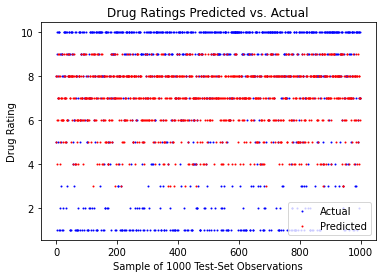

In [147]:
plotGraph(sample_df['rating'], sample_df['prediction_ints'], "Drug Ratings Predicted vs. Actual")

In [150]:
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(test_preds)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 2.9471868507249805


In [149]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(test_preds_df['rating'], test_preds_df['prediction_ints'], squared=False)
print("RMSE with rounded predictions to nearest integer =", rms)

RMSE with rounded predictions to nearest integer =  2.961482051245562


### Write Out Model and Demo Inference Requirements

In [ ]:
# https://www.sparkitecture.io/machine-learning/model-saving-and-loading

In [ ]:
rf_pipelineModel.write().overwrite().save(working_folder + "pipeline_saved_model")

In [ ]:
from pyspark.ml import PipelineModel
from textblob import TextBlob

In [ ]:
review_sent = TextBlob('This drug is the worst!').sentiment.polarity

In [ ]:
new_data = pd.DataFrame.from_dict({'usefulCount':[1],'sentiment':review_sent})

In [ ]:
new_data = spark.createDataFrame(new_data)

In [ ]:
new_data.show()

In [ ]:
test_pipelineModel = PipelineModel.load(working_folder + 'pipeline_saved_model')

In [ ]:
test_pipelineModel.transform(new_data).show()

# Attempt at Using John Snow Labs pretrained sentiment model pipeline
https://nlp.johnsnowlabs.com/

Medium Article: 
https://medium.com/analytics-vidhya/sentiment-analysis-with-sparknlp-couldnt-be-easier-2a8ea3b728a0

John Snow Labs Reference Notebook: 
https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/quick_start_google_colab.ipynb#scrollTo=tyMMD_upEfIa

This model using BioBERT would potentially perform better, but it is not free-tier:
https://nlp.johnsnowlabs.com/2022/07/28/bert_sequence_classifier_drug_reviews_webmd_en_3_0.html

Breakdown how pretrained pipeline works under the hood: https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/SENTIMENT_EN.ipynb

In [ ]:
pipeline = PretrainedPipeline('analyze_sentimentdl_use_twitter', 'en')

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[OK!]


In [ ]:
pipeline.model.stages

[DocumentAssembler_bc88e2e1b2ae,
 UNIVERSAL_SENTENCE_ENCODER_4de71669b7ec,
 SentimentDLModel_eca587b575f7]

Universal Sentence Encoder: https://nlp.johnsnowlabs.com/2020/04/17/tfhub_use.html

In [ ]:
# rename the text column as 'text', pipeline expects 'text' 
df_result = pipeline.transform(df.withColumnRenamed("review", "text"))

In [ ]:
test = pipeline.annotate("Holy Hell is exactly how I feel. I had been taking Brisdelle for 1.5 years. The hot flashes did indeed subside - however, the side affects of this medicine coupled with the fact Noven was acquired by YET another pharmaceutical company - YOU CAN&#039;T PLACE A REP IN THE AREA, DISTRIBUTE YOUR DRUGS, AND THEN FIRE HER-AND NOT REPLACE THEREFORE there is NO medicine or support here. You dumped this drug in the Dr&#039;s hands and walked away. After calling Sebula - you act like you don&#039;t even care. You have made it impossible to obtain this. I happen to think this is illegal.  I just decided to wean myself off this and Premarin. It has been nothing short of a nightmare. If you don&#039;t need this drug- DON&#039;T START. Seriously.")

In [ ]:
test

{'document': ['Holy Hell is exactly how I feel. I had been taking Brisdelle for 1.5 years. The hot flashes did indeed subside - however, the side affects of this medicine coupled with the fact Noven was acquired by YET another pharmaceutical company - YOU CAN&#039;T PLACE A REP IN THE AREA, DISTRIBUTE YOUR DRUGS, AND THEN FIRE HER-AND NOT REPLACE THEREFORE there is NO medicine or support here. You dumped this drug in the Dr&#039;s hands and walked away. After calling Sebula - you act like you don&#039;t even care. You have made it impossible to obtain this. I happen to think this is illegal.  I just decided to wean myself off this and Premarin. It has been nothing short of a nightmare. If you don&#039;t need this drug- DON&#039;T START. Seriously.'],
 'sentence_embeddings': ['Holy Hell is exactly how I feel. I had been taking Brisdelle for 1.5 years. The hot flashes did indeed subside - however, the side affects of this medicine coupled with the fact Noven was acquired by YET another p

In [ ]:
print(df_result)

DataFrame[UniqueID: int, drugName: string, condition: string, text: string, rating: double, date: string, usefulCount: int, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence_embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentiment: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]


In [ ]:
# extract results from "sentiments" column
df_result = df_result.withColumn("sentiment", explode('sentiment.result'))

In [ ]:
df_result.show()

+--------+--------------------+--------------------+--------------------+------+------------------+-----------+--------------------+--------------------+---------+
|UniqueID|            drugName|           condition|                text|rating|              date|usefulCount|            document| sentence_embeddings|sentiment|
+--------+--------------------+--------------------+--------------------+------+------------------+-----------+--------------------+--------------------+---------+
|  206461|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|      May 20, 2012|         27|[{document, 0, 78...|[{sentence_embedd...| negative|
|   95260|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|    April 27, 2010|        192|[{document, 0, 73...|[{sentence_embedd...| negative|
|   92703|              Lybrel|       Birth Control|"I used to take a...|   5.0| December 14, 2009|         17|[{document, 0, 75...|[{sentence_embedd...| negative|
|  138000|      